# Lab 9 - Association Rule Mining

The following exercise follows the CRISP-DM data science methodology.

---

## Business Scenario

Roger is a city manager for a medium-sized, but steadily growing, city.
He needs to get a number of groups to work together to meet some of the needs in the community, knowing that the citizens in the community are fairly active in various community organizations such as churches, social clubs, hobby enthusiasts and other types of groups in the community.
What he doesn't know is if there are connections between the groups that might enable natural collaborations between two or more groups that could work together on projects around town.
He decides that before he can begin asking community organizations to begin working together and to accept responsibility for projects, he needs to find out if there are any existing associations between the different types of groups in the area.

## Business Understanding

**Business Goal**: Roger's goal is to identify and then try to take advantage of existing connections/associations in his local community to get some work done that will benefit the entire community.

**Data Mining Goal**: identifying strong and frequent associations between the groups using association rule mining.

## Data Understanding

```raw
Elapsed_Time: the amount of time each respondent spent completing our survey. It is expressed in decimal minutes.

Time_in_Community: This question on the survey asked the person if they have lived in the area for 0-2 years, 3-9 years, or 10+ years; and is recorded in the data set as Short, Medium, or Long respectively.

Gender: The survey respondent's gender.

Working: A yes/no column indicating whether or not the respondent currently has a paid job

Age: The survey respondent's age in years.

Family: A yes/no column indicating whether or not the respondent is currently a member of a family-oriented community organization, such as Big Brothers/Big Sisters, etc.

Hobbies: A yes/no column indicating whether or not the respondent is currently a member of a hobby-oriented community organization, such as amateur radio, etc.

Social_Club: A yes/no column indicating whether or not the respondent is currently a member of a community social organization, such as Rotary International, Lion's Club, etc.

Political: A yes/no column indicating whether or not the respondent is currently a member of a political organization, such as a political party, etc.

Professional: A yes/no column indicating whether or not the respondent is currently a member of a professional organization such as a chapter of a law or medical society, etc.

Religious: A yes/no column indicating whether or not the respondent is currently a member of a church in the community.

Support_Group: A yes/no column indicating whether or not the respondent is currently a member of a support-oriented community organization, such as Alcoholics Anonymous, etc.
```

## Data Preparation

The data URL is `https://raw.githubusercontent.com/GUC-DM/W2023/main/data/groups_survey.csv`

In [1]:
# Execute this cell if running locally or on Colab
# to install the mlxtend package for assoc. rule

# !pip install mlxtend --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/Summer2025/refs/heads/main/data/groups_survey.csv')
df.head()

,Elapsed_Time,Time_in_Community,Gender,Working,Age,Family,Hobbies,Social_Club,Political,Professional,Religious,Support_Group
0,8.71,Short,M,No,53,1,0,0,0,0,0,0
1,5.24,Medium,F,No,31,0,0,0,0,0,1,1
2,4.22,Medium,M,No,42,1,1,0,0,1,0,0
3,4.81,Long,F,No,30,0,0,0,0,0,0,0
4,3.95,Long,M,Yes,29,0,0,0,1,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3483 entries, 0 to 3482
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Elapsed_Time       3483 non-null   float64
 1   Time_in_Community  3483 non-null   object 
 2   Gender             3483 non-null   object 
 3   Working            3483 non-null   object 
 4   Age                3483 non-null   int64  
 5   Family             3483 non-null   int64  
 6   Hobbies            3483 non-null   int64  
 7   Social_Club        3483 non-null   int64  
 8   Political          3483 non-null   int64  
 9   Professional       3483 non-null   int64  
 10  Religious          3483 non-null   int64  
 11  Support_Group      3483 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 326.7+ KB


In [5]:
# Since we need to find out if there are any existing associations between the different types of groups,
# We need to select the types of groups relevant columns

enc_df = df.loc[:, 'Family':'Support_Group']
enc_df.head()

,Family,Hobbies,Social_Club,Political,Professional,Religious,Support_Group
0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,1
2,1,1,0,0,1,0,0
3,0,0,0,0,0,0,0
4,0,0,0,1,1,0,1


In [6]:
#In order to use Apriori/ FP Growth, it's better to convert our dataframe data type to Boolean.

# DataFrames with non-bool types result in worse computational performance
# and their support might be discontinued in the future.

enc_df= enc_df.astype(bool)
enc_df.head()

,Family,Hobbies,Social_Club,Political,Professional,Religious,Support_Group
0,True,False,False,False,False,False,False
1,False,False,False,False,False,True,True
2,True,True,False,False,True,False,False
3,False,False,False,False,False,False,False
4,False,False,False,True,True,False,True


Quick visualization to better understand the groups that respondents have joined.

/tmp/ipython-input-7-654618193.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels(bar.get_xticklabels(), rotation='vertical');


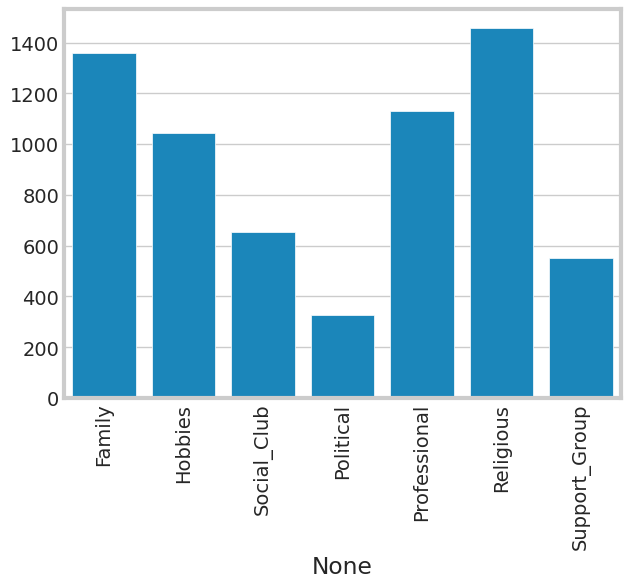

In [7]:
count = enc_df.sum()
bar = sns.barplot(x=count.index, y=count.values)
bar.set_xticklabels(bar.get_xticklabels(), rotation='vertical');

## Modelling

Since the business owner is looking for connections between groups, we'll prioritize confidence (i.e., we are confident that the connection between the groups exist) rather than its support (i.e., the proportion of respondents that are part of the group(s)). Thus, we'll set a relatively low support threshold (5%) to get a few 'frequent' pairings, and then create association rules using a relatively high confidence threshold (60%).

**Note**: In this case, we may even just use the results from the frequent itemsets per group, and recommend based on that, since that would accomplish the purpose of utilizing the frequent connections between different groups.

**Use `%timeit` to get the execution time for the Apriori Algorithm**

In [8]:
from mlxtend.frequent_patterns import apriori, association_rules


freq_items = apriori(enc_df, min_support=0.05, use_colnames=True)
freq_items.sort_values('support', ascending=False)


,support,itemsets
5,0.418605,(Religious)
0,0.389894,(Family)
4,0.324433,(Professional)
1,0.300029,(Hobbies)
14,0.238875,"(Religious, Hobbies)"
10,0.224519,"(Family, Religious)"
2,0.188056,(Social_Club)
7,0.186908,"(Family, Hobbies)"
6,0.158771,(Support_Group)
23,0.154752,"(Family, Religious, Hobbies)"


In [9]:
%timeit freq_items = apriori(enc_df, min_support=0.05, use_colnames=True)

3.49 ms ± 97.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
association_rules(freq_items, metric='confidence', min_threshold=0.60, num_itemsets=len(enc_df)).sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Hobbies),(Religious),0.300029,0.418605,0.238875,0.796172,1.901967,1.0,0.113281,2.852386,0.677497,0.497905,0.649416,0.683408
0,(Hobbies),(Family),0.300029,0.389894,0.186908,0.622967,1.597785,1.0,0.069929,1.618175,0.534499,0.371575,0.382020,0.551174
8,"(Family, Religious)",(Hobbies),0.224519,0.300029,0.154752,0.689258,2.297308,1.0,0.087389,2.252583,0.728203,0.418478,0.556065,0.602524
10,"(Religious, Hobbies)",(Family),0.238875,0.389894,0.154752,0.647837,1.661572,1.0,0.061616,1.732452,0.523120,0.326469,0.422783,0.522372
9,"(Family, Hobbies)",(Religious),0.186908,0.418605,0.154752,0.827957,1.977897,1.0,0.076511,3.379360,0.608065,0.343312,0.704086,0.598821
4,(Social_Club),(Religious),0.188056,0.418605,0.147287,0.783206,1.870992,1.0,0.068566,2.681788,0.573345,0.320625,0.627115,0.567529
1,(Social_Club),(Family),0.188056,0.389894,0.128912,0.685496,1.758161,1.0,0.055590,1.939901,0.531101,0.287084,0.484510,0.508065
2,(Social_Club),(Hobbies),0.188056,0.300029,0.123457,0.656489,2.188086,1.0,0.067035,2.037694,0.668740,0.338583,0.509249,0.533986
14,"(Hobbies, Social_Club)",(Religious),0.123457,0.418605,0.109676,0.888372,2.122222,1.0,0.057996,5.208333,0.603274,0.253652,0.808000,0.575187
13,"(Religious, Social_Club)",(Hobbies),0.147287,0.300029,0.109676,0.744639,2.481894,1.0,0.065485,2.741109,0.700214,0.324830,0.635184,0.555095


Since we haven't observed any itemsets containing political or support groups, and we want to offer recommendations for all the communities, we'll have a look at the overlap between each group by building the frequent itemsets for each of those groups independently.

In [11]:
freq_items = apriori(enc_df[enc_df['Political'] == 1], min_support=0.05, use_colnames=True)
freq_items.nlargest(15, 'support')

,support,itemsets
3,1.000000,(Political)
4,0.532110,(Professional)
22,0.532110,"(Political, Professional)"
0,0.434251,(Family)
9,0.434251,"(Family, Political)"
5,0.425076,(Religious)
23,0.425076,"(Political, Religious)"
6,0.370031,(Support_Group)
24,0.370031,"(Political, Support_Group)"
1,0.351682,(Hobbies)


In [12]:
freq_items = apriori(enc_df[enc_df['Support_Group'] == 1], min_support=0.05, use_colnames=True)
freq_items.nlargest(15, 'support')

,support,itemsets
6,1.000000,(Support_Group)
5,0.433996,(Religious)
27,0.433996,"(Religious, Support_Group)"
0,0.428571,(Family)
12,0.428571,"(Family, Support_Group)"
4,0.415913,(Professional)
26,0.415913,"(Professional, Support_Group)"
1,0.377939,(Hobbies)
17,0.377939,"(Hobbies, Support_Group)"
16,0.301989,"(Religious, Hobbies)"


## Conclusions

**A few interesting association rules**:

- If a person is part of a hobbies group, they are very likely to also be part of a religious group (~80% confidence)
- If a person is part of a hobbies group, they are likely to also be part of a family group (~62% confidence)
- If a person is part of a social club group, they are very likely to also be part of a religious group (~78% confidence)
- If a person is part of a social club AND religious group, they are extremely likely to also be part of a hobbies group (~74% confidence)

**A few recommendations based on the frequent item sets and association rules, to get the most shared connections between each group**:

- Social clubs or hobbies group members are best paired with religious groups
- Family groups are best paired with social clubs, hobbies or religious groups
- Professional groups are best paired with hobbies or family groups
- Political groups are best paired with professional or family groups
- Support groups are best paired with religious or family groups

## Extra Challenge

#### Use FP Growth Algorithm instead of Apriori and compare the results (use `%timeit` to compare the execution time of both of them)

In [13]:
from mlxtend.frequent_patterns import fpgrowth

freq_items = fpgrowth(enc_df, min_support=0.05 ,use_colnames=True)
freq_items.sort_values('support', ascending=False)

,support,itemsets
1,0.418605,(Religious)
0,0.389894,(Family)
3,0.324433,(Professional)
4,0.300029,(Hobbies)
17,0.238875,"(Religious, Hobbies)"
7,0.224519,"(Family, Religious)"
6,0.188056,(Social_Club)
15,0.186908,"(Family, Hobbies)"
2,0.158771,(Support_Group)
18,0.154752,"(Family, Religious, Hobbies)"


In [14]:
%timeit freq_items = fpgrowth(enc_df, min_support=0.05 ,use_colnames=True)

273 ms ± 73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
association_rules(freq_items, metric='confidence', min_threshold=0.60, num_itemsets= len(enc_df)).sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,(Hobbies),(Religious),0.300029,0.418605,0.238875,0.796172,1.901967,1.0,0.113281,2.852386,0.677497,0.497905,0.649416,0.683408
0,(Hobbies),(Family),0.300029,0.389894,0.186908,0.622967,1.597785,1.0,0.069929,1.618175,0.534499,0.371575,0.382020,0.551174
2,"(Family, Religious)",(Hobbies),0.224519,0.300029,0.154752,0.689258,2.297308,1.0,0.087389,2.252583,0.728203,0.418478,0.556065,0.602524
3,"(Family, Hobbies)",(Religious),0.186908,0.418605,0.154752,0.827957,1.977897,1.0,0.076511,3.379360,0.608065,0.343312,0.704086,0.598821
4,"(Religious, Hobbies)",(Family),0.238875,0.389894,0.154752,0.647837,1.661572,1.0,0.061616,1.732452,0.523120,0.326469,0.422783,0.522372
8,(Social_Club),(Religious),0.188056,0.418605,0.147287,0.783206,1.870992,1.0,0.068566,2.681788,0.573345,0.320625,0.627115,0.567529
9,(Social_Club),(Family),0.188056,0.389894,0.128912,0.685496,1.758161,1.0,0.055590,1.939901,0.531101,0.287084,0.484510,0.508065
10,(Social_Club),(Hobbies),0.188056,0.300029,0.123457,0.656489,2.188086,1.0,0.067035,2.037694,0.668740,0.338583,0.509249,0.533986
14,"(Hobbies, Social_Club)",(Religious),0.123457,0.418605,0.109676,0.888372,2.122222,1.0,0.057996,5.208333,0.603274,0.253652,0.808000,0.575187
13,"(Religious, Social_Club)",(Hobbies),0.147287,0.300029,0.109676,0.744639,2.481894,1.0,0.065485,2.741109,0.700214,0.324830,0.635184,0.555095


## Conclusions

**Execution Time**:

The `FP Growth` Algorithm execution time is 49 milliseconds, while that of the `Apriori` is 11.1 milliseconds. So, Apriori is faster in our case.

<br/>

**The results show the Same interesting association rules as the ones with Apriori**:

- If a person is part of a hobbies group, they are very likely to also be part of a religious group (~80% confidence)
- If a person is part of a hobbies group, they are likely to also be part of a family group (~62% confidence)
- If a person is part of a social club group, they are very likely to also be part of a religious group (~78% confidence)
- If a person is part of a social club AND religious group, they are extremely likely to also be part of a hobbies group (~74% confidence)


**A few recommendations based on the frequent item sets and association rules, to get the most shared connections between each group**:

- Social clubs or hobbies group members are best paired with religious groups
- Family groups are best paired with social clubs, hobbies or religious groups
- Professional groups are best paired with hobbies or family groups
- Political groups are best paired with professional or family groups
- Support groups are best paired with religious or family groups